# Food vision Project

In [3]:
!nvidia-smi

Mon Feb 20 14:51:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use Tensorflow datasets to download data

In [5]:
# Get tensorflow datasets
import tensorflow_datasets as tfds

In [6]:
#List all available datasets
datasets_list=tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list)

True


In [7]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete56NYMN/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete56NYMN/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from Tensorflow datasets
To become one with our data , we want to find:
* Class names
* The shape of our input data(image tensors)
* The datatype of input data
* What the labels looks like (eg. are they one-hot encoded or they label encoded)
* Do the labels match up with class names

In [8]:
# Features of food101 from tsds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Get the class names
class_names=ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of train data
train_one_sample=train_data.take(1) #Tensor are in format (image_tensor,label)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about training sample
for image,label in train_one_sample:
    print(f"""
     Image shape:{image.shape},
     Image datatype:{image.dtype},
     Target class from Food101 (tensor form):{label}
     Class name (str form):{class_names[label.numpy()]}
    """
    )


     Image shape:(512, 289, 3),
     Image datatype:<dtype: 'uint8'>,
     Target class from Food101 (tensor form):45
     Class name (str form):frozen_yogurt
    


In [12]:
#What does our image from TFDS food 101 looks like?
image

<tf.Tensor: shape=(512, 289, 3), dtype=uint8, numpy=
array([[[145, 151, 125],
        [157, 163, 137],
        [159, 165, 139],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [197, 207, 198]],

       [[146, 152, 126],
        [156, 162, 136],
        [158, 164, 138],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 200]],

       [[150, 156, 130],
        [155, 161, 135],
        [157, 163, 137],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 198]],

       ...,

       [[173, 186, 177],
        [174, 187, 178],
        [176, 189, 180],
        ...,
        [181, 197, 187],
        [181, 197, 187],
        [178, 195, 187]],

       [[176, 187, 179],
        [176, 187, 179],
        [176, 189, 180],
        ...,
        [182, 198, 188],
        [182, 198, 188],
        [180, 197, 189]],

       [[178, 189, 181],
        [177, 188, 180],
        [175, 188, 179],
        ...,
        [179, 195, 18

In [13]:
import tensorflow as tf

In [14]:
# What are the min and max values of our image tensor?
tf.reduce_min(image) , tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

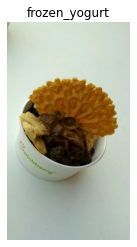

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to  verify label is associated with the right
plt.axis(False);

# Create preprocessing functions for our data

Neural networks perform best when data is in a certain way(batched,normalized,etc.)

However ,not all data (including from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network , Write preprocessing functions and map it to our data.

What we know about our data:
* Datatype :uinit8
* Different size images
* Not scaled

What's recommed for model:
* Datatype needed Flot32 dtype or flot16
* For batches , need them in same size of batch
* Scaled (values between 0-1) /normalized

Therefore making a function need to  :
1. Reshape our image to all same size
2. Convert the dtype of our image tensors from 'unit8' to flot32


In [16]:
#Make a function for preprocessing images

def preprocess_image(image,label,img_shape=224):
    """
    Converts iage datatype from unit8 -> flot32 and reshapes image to 
    
    [img_shape,img_shape,color_channels].
    """
    image=tf.image.resize(image,[img_shape,img_shape]) #reshape target image
#     image=image/255.   
    return tf.cast(image,tf.float32),label #return (float32_image,label) tuple
    

In [17]:
# Preprocess a single sample image and check the outputs
preprocessed_img=preprocess_image(image,label)[0]
print(f"Image before preprocessing:\n {image[:2]} ...,\nShape:{image.shape} , \n Datatype:{image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...., \nShape:{preprocessed_img.shape} ,\n Datatype:{preprocessed_img.dtype}")


Image before preprocessing:
 [[[145 151 125]
  [157 163 137]
  [159 165 139]
  ...
  [197 209 199]
  [197 209 199]
  [197 207 198]]

 [[146 152 126]
  [156 162 136]
  [158 164 138]
  ...
  [197 209 199]
  [197 209 199]
  [199 209 200]]] ...,
Shape:(512, 289, 3) , 
 Datatype:<dtype: 'uint8'>

Image after preprocessing:
[[[147.19739 153.19739 127.19739]
  [157.22768 163.22768 137.22768]
  [158.09805 164.09805 138.09805]
  ...
  [197.      209.      197.54907]
  [197.      209.      199.     ]
  [198.09914 208.38936 199.24425]]

 [[154.69467 160.69467 134.69467]
  [155.87053 161.87053 135.87053]
  [158.39908 164.39908 138.39908]
  ...
  [197.      209.      197.54907]
  [197.      209.      199.     ]
  [196.32831 206.61853 195.76364]]]...., 
Shape:(224, 224, 3) ,
 Datatype:<dtype: 'float32'>


## Batch and prepare datasets
Making data input pipeline

In [18]:
#map preprocessing function to training data (and parallelize)
train_data=train_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)

#Shuffle train data and turn it into batches and prefetch it (load it faster)
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

#Map preprocessing func to test data
test_data=test_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [19]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks
We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results
* ModelCheckpoint callback to save model progress

In [20]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create model checkpoint callback 
checkpoint_path="model_checkpoints/cp.ckpt"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor="val_accuracy",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=0
                                                   )

## Mixed precision Training

In [21]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")

# Build feature extraction model


In [22]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create functional model
inputs=layers.Input(shape=input_shape,name="Input_layer")
# x=preprocessing.Rescaling(1/255.)(x) if we dont have rescale layer
x=base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)
outputs=layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
model=tf.keras.Model(inputs,outputs)

#Compile the model
model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"]
             )

16705208/16705208 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision?)

In [24]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

Input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [25]:
# Check the dtype_policy attributes of layers in our  base model
for layer in model.layers[1].layers:
    print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
rescaling_1 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">
block2a_expand_activation False f

In [26]:
# Fit the feature extraction model
history_101_food_classes_feature_extract=model.fit(train_data,
                                                   validation_data=test_data,
                                                   validation_steps=len(test_data),
                                                   epochs=3,
                                                   steps_per_epoch=len(train_data),
                                                   callbacks=[create_tensorboard_callback(dir_name="Training_logs",
                                                                                         experiment_name="efficientnetb0_101_classes_all_data"
                                                                                         ),model_checkpoint] )

Saving TensorBoard log files to: Training_logs/efficientnetb0_101_classes_all_data/20230220-150711


Epoch 1/3
2368/2368 [==============================] - 283s 112ms/step - loss: 1.7182 - accuracy: 0.5825 - val_loss: 1.1359 - val_accuracy: 0.6979
Epoch 2/3
2368/2368 [==============================] - 238s 100ms/step - loss: 1.1990 - accuracy: 0.6889 - val_loss: 1.0394 - val_accuracy: 0.7192
Epoch 3/3
2368/2368 [==============================] - 234s 98ms/step - loss: 1.0551 - accuracy: 0.7238 - val_loss: 0.9964 - val_accuracy: 0.7278


In [27]:
# Evaluate on whole test dataset
results_feature_extract_model=model.evaluate(test_data)

790/790 [==============================] - 55s 69ms/step - loss: 0.9964 - accuracy: 0.7278


In [28]:
# model.save_weights("Feature_extraction.h5")

# Fine-tuning our model

In [29]:
base_model.trainable=True

for layer in base_model.layers[:-10]:
    layer.trainable=False

In [30]:
for layer in base_model.layers:
    print(layer.name,layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_proj

In [31]:
model.compile(
 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
metrics=["accuracy"]
)

In [32]:
fine_tune_epoch=7

In [33]:
# Fit the fine-tune  model
history_101_food_classes_fine_tune=model.fit(train_data,
                                                   validation_data=test_data,
                                                   validation_steps=len(test_data),
                                                   epochs=fine_tune_epoch,
                                                   steps_per_epoch=len(train_data),
                                                   callbacks=[create_tensorboard_callback(dir_name="Training_logs",
                                                                                         experiment_name="efficientnetb0_101_classes_all_data"
                                                                                         ),model_checkpoint],
                                                   initial_epoch=history_101_food_classes_feature_extract.epoch[-1]
                                            )

Saving TensorBoard log files to: Training_logs/efficientnetb0_101_classes_all_data/20230220-152218
Epoch 3/7
2368/2368 [==============================] - 285s 114ms/step - loss: 0.8682 - accuracy: 0.7694 - val_loss: 0.9107 - val_accuracy: 0.7494
Epoch 4/7
2368/2368 [==============================] - 241s 101ms/step - loss: 0.7258 - accuracy: 0.8064 - val_loss: 0.8935 - val_accuracy: 0.7522
Epoch 5/7
2368/2368 [==============================] - 234s 98ms/step - loss: 0.6202 - accuracy: 0.8360 - val_loss: 0.8958 - val_accuracy: 0.7558
Epoch 6/7
2368/2368 [==============================] - 265s 111ms/step - loss: 0.5316 - accuracy: 0.8610 - val_loss: 0.9036 - val_accuracy: 0.7546
Epoch 7/7
2368/2368 [==============================] - 241s 101ms/step - loss: 0.4528 - accuracy: 0.8836 - val_loss: 0.9213 - val_accuracy: 0.7533


In [34]:
model.evaluate(test_data)

790/790 [==============================] - 55s 69ms/step - loss: 0.9213 - accuracy: 0.7533


[0.9213318228721619, 0.7533069252967834]

In [35]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Making Confusion matrix

In [36]:
preds_probs=model.predict(test_data,verbose=1)

790/790 [==============================] - 59s 72ms/step


In [37]:
preds_probs.shape

(25250, 101)

In [38]:
preds_probs[0]

array([3.38499717e-06, 3.23360691e-05, 1.85317858e-05, 3.35558355e-01,
       3.78415994e-02, 1.80558767e-04, 3.80092509e-08, 6.32956755e-07,
       1.75210869e-06, 3.87594155e-05, 2.38078833e-02, 5.15271118e-03,
       6.91892321e-09, 1.07058419e-04, 5.36009175e-08, 4.30599675e-02,
       2.33023698e-07, 5.29434858e-03, 6.71499492e-06, 5.50595997e-03,
       3.65019878e-05, 2.97025871e-08, 7.15647445e-07, 1.32876654e-09,
       2.57212814e-04, 3.88444029e-03, 4.19013340e-05, 4.12819730e-07,
       3.43224224e-06, 3.12731316e-08, 6.09775889e-05, 2.86973602e-07,
       9.55999667e-07, 3.19452488e-06, 1.52935871e-04, 1.44456164e-03,
       5.31578204e-04, 1.79561932e-04, 1.82120311e-06, 1.93277616e-02,
       4.69829274e-07, 8.05764699e-08, 1.20976745e-06, 9.04061562e-06,
       1.66657526e-04, 1.39540816e-07, 2.59681983e-04, 1.34300848e-04,
       1.27075678e-02, 2.12809668e-04, 9.63382772e-05, 1.78120405e-04,
       1.75328194e-06, 1.89350671e-04, 3.06194096e-07, 3.93724185e-05,
      

In [39]:
sum(preds_probs[0])

1.0000000591001053

In [40]:
# We get one prediction probablity per class
print(f"No of prediction prbabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probablity sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with highest prediction probablity by the model for sample 0: {preds_probs[0].argmax()}")

No of prediction prbabilities for sample 0: 101
What prediction probablity sample 0 looks like:
 [3.38499717e-06 3.23360691e-05 1.85317858e-05 3.35558355e-01
 3.78415994e-02 1.80558767e-04 3.80092509e-08 6.32956755e-07
 1.75210869e-06 3.87594155e-05 2.38078833e-02 5.15271118e-03
 6.91892321e-09 1.07058419e-04 5.36009175e-08 4.30599675e-02
 2.33023698e-07 5.29434858e-03 6.71499492e-06 5.50595997e-03
 3.65019878e-05 2.97025871e-08 7.15647445e-07 1.32876654e-09
 2.57212814e-04 3.88444029e-03 4.19013340e-05 4.12819730e-07
 3.43224224e-06 3.12731316e-08 6.09775889e-05 2.86973602e-07
 9.55999667e-07 3.19452488e-06 1.52935871e-04 1.44456164e-03
 5.31578204e-04 1.79561932e-04 1.82120311e-06 1.93277616e-02
 4.69829274e-07 8.05764699e-08 1.20976745e-06 9.04061562e-06
 1.66657526e-04 1.39540816e-07 2.59681983e-04 1.34300848e-04
 1.27075678e-02 2.12809668e-04 9.63382772e-05 1.78120405e-04
 1.75328194e-06 1.89350671e-04 3.06194096e-07 3.93724185e-05
 4.59960902e-05 2.11425606e-04 3.22192209e-05 3.9

In [41]:
pred_classes=preds_probs.argmax(axis=1)
pred_classes[:10]

array([ 3, 98, 22, 59, 12, 26, 90,  6, 23, 71])

In [42]:
len(pred_classes)

25250

In [43]:
# Define a function to extract the labels
def extract_labels(image, label):
    return label

In [44]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [45]:
# Map the function to the test dataset to extract the labels
test_labels = test_data.map(extract_labels)

In [48]:
# Convert the labels to a numpy array for further analysis
import numpy as np
test_labels = np.concatenate(list(test_labels.as_numpy_iterator()))

In [49]:
y_labels=test_labels

In [50]:
len(y_labels)

25250

In [51]:
y_labels[:10]

array([37, 99, 40, 60,  1, 69, 52, 62, 77, 67])

## Evaluating model's prediction

In [52]:
from sklearn.metrics import accuracy_score
sklearn_accuracy=accuracy_score(y_true=y_labels,
                                y_pred=pred_classes
                               )

In [53]:
sklearn_accuracy

0.009188118811881188

## Confusion Matrix

In [54]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [55]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

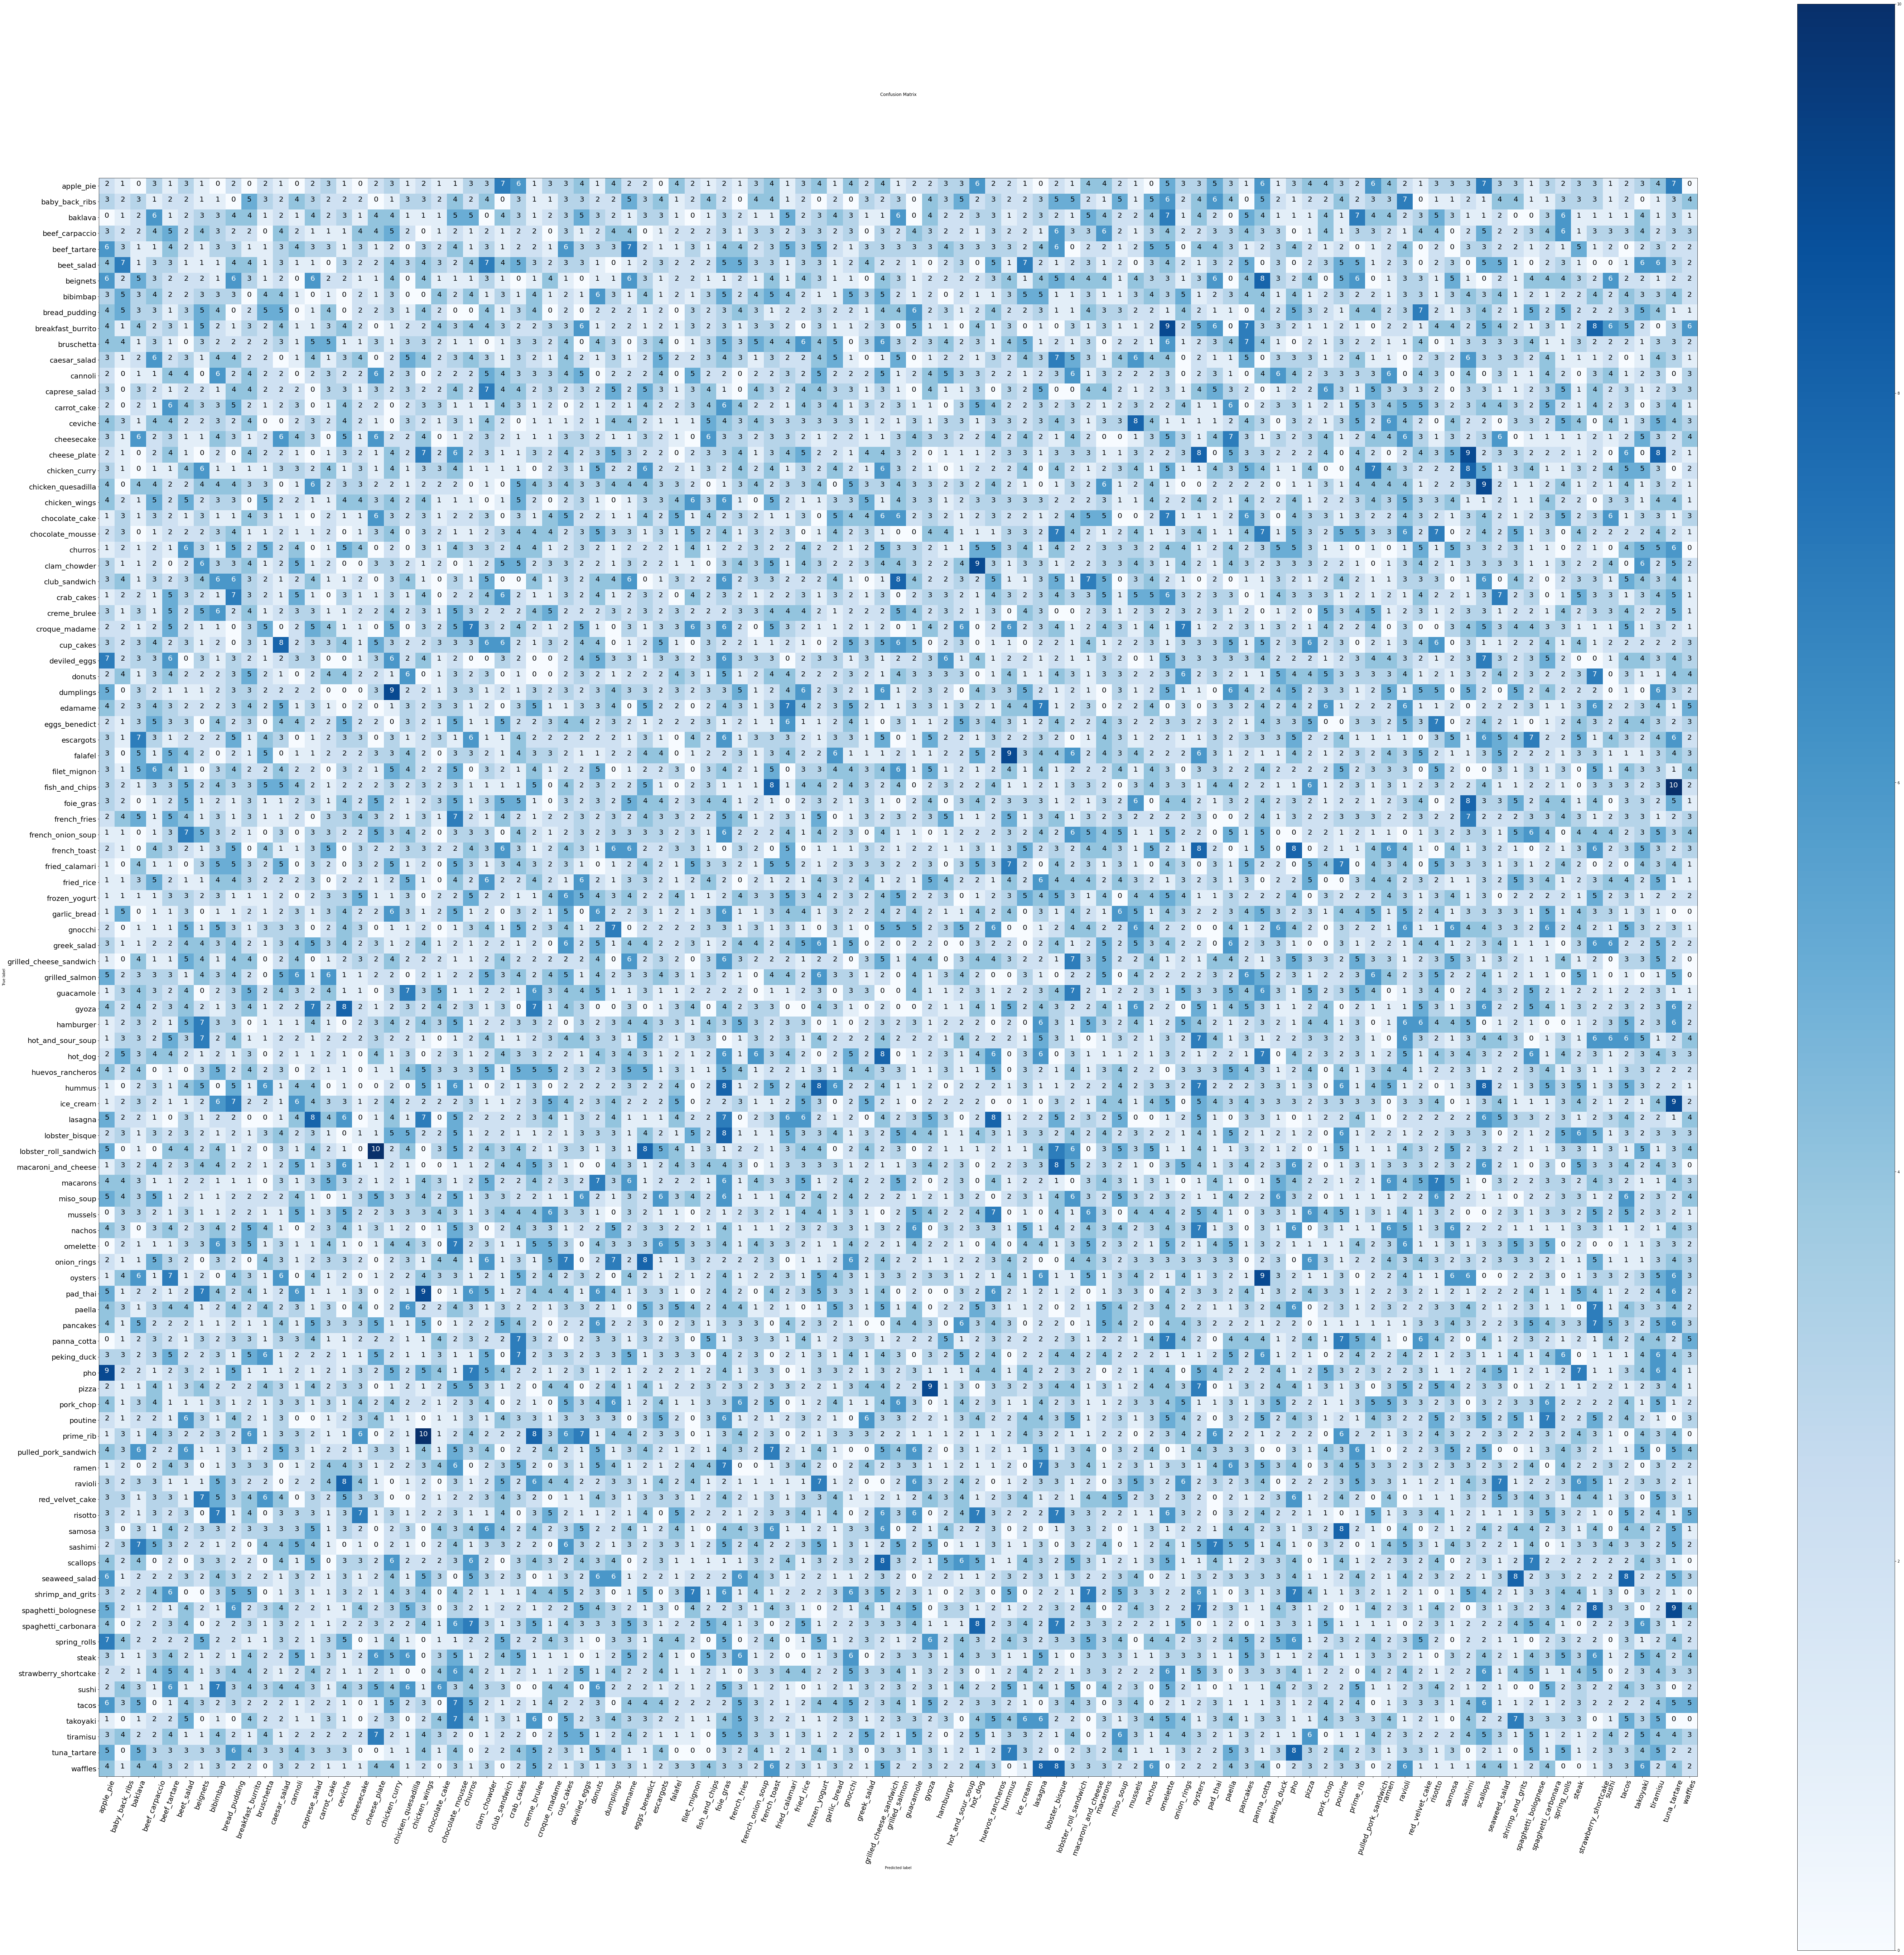

In [56]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)
     

## Using different Application


In [57]:
base_model_2=tf.keras.applications.EfficientNetB4(include_top=False)
base_model_2.trainable=False
inputs=tf.keras.Input(shape=(224,224,3),name="Input_layer")
x=base_model_2(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)
outputs=layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
model_2=tf.keras.Model(inputs,outputs)

71686520/71686520 [==============================] - 0s 0us/step


In [58]:
model_2.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"]  
)

In [59]:
history_101_food_classes_feature_extract_1=model_2.fit(train_data,
                                                   validation_data=test_data,
                                                   validation_steps=len(test_data),
                                                   epochs=3,
                                                   steps_per_epoch=len(train_data),
                                                   callbacks=[create_tensorboard_callback(dir_name="Training_logs",
                                                                                         experiment_name="efficientnetb4_101_classes_all_data"
                                                                                         ),model_checkpoint] )

Saving TensorBoard log files to: Training_logs/efficientnetb4_101_classes_all_data/20230220-155445
Epoch 1/3
2368/2368 [==============================] - 489s 200ms/step - loss: 1.7884 - accuracy: 0.5573 - val_loss: 1.2563 - val_accuracy: 0.6679
Epoch 2/3
2368/2368 [==============================] - 504s 212ms/step - loss: 1.3072 - accuracy: 0.6587 - val_loss: 1.1615 - val_accuracy: 0.6865
Epoch 3/3
2368/2368 [==============================] - 503s 211ms/step - loss: 1.1603 - accuracy: 0.6944 - val_loss: 1.1248 - val_accuracy: 0.6959


In [60]:
model_2.save_weights("Ep_3.h5")

In [61]:
three_more_epoch=6

In [62]:
history_101_food_classes_feature_extract_2=model_2.fit(train_data,
                                                   validation_data=test_data,
                                                   validation_steps=len(test_data),
                                                   epochs=three_more_epoch,
                                                   steps_per_epoch=len(train_data),
                                                   callbacks=[create_tensorboard_callback(dir_name="Training_logs",
                                                                                         experiment_name="efficientnetb4_101_classes_all_data"
                                                                                         ),model_checkpoint],
                                                      initial_epoch=history_101_food_classes_feature_extract_1.epoch[-1]
                                                      )

Saving TensorBoard log files to: Training_logs/efficientnetb4_101_classes_all_data/20230220-162041


Epoch 3/6
2368/2368 [==============================] - 505s 212ms/step - loss: 1.0620 - accuracy: 0.7175 - val_loss: 1.0974 - val_accuracy: 0.7011
Epoch 4/6
2368/2368 [==============================] - 473s 198ms/step - loss: 0.9889 - accuracy: 0.7365 - val_loss: 1.0852 - val_accuracy: 0.7070
Epoch 5/6
2368/2368 [==============================] - 471s 198ms/step - loss: 0.9292 - accuracy: 0.7513 - val_loss: 1.0869 - val_accuracy: 0.7034
Epoch 6/6
2368/2368 [==============================] - 503s 211ms/step - loss: 0.8762 - accuracy: 0.7658 - val_loss: 1.0786 - val_accuracy: 0.7078


In [63]:
#Fine-tuning
base_model_2.trainable=True

for layer in base_model_2.layers[:-5]:
    layer.trainable=False

In [64]:
model_2.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  metrics=["accuracy"]  
)

In [65]:
six_more=12

In [66]:
history_101_food_classes_fine_tune_2=model_2.fit(train_data,
                                                   validation_data=test_data,
                                                   validation_steps=len(test_data),
                                                   epochs=six_more,
                                                   steps_per_epoch=len(train_data),
                                                   callbacks=[create_tensorboard_callback(dir_name="Training_logs",
                                                                                         experiment_name="efficientnetb4_101_classes_all_data"
                                                                                         ),model_checkpoint],
                                                      initial_epoch=history_101_food_classes_feature_extract_2.epoch[-1]
                                                      )

Saving TensorBoard log files to: Training_logs/efficientnetb4_101_classes_all_data/20230220-165542
Epoch 6/12
2368/2368 [==============================] - 525s 215ms/step - loss: 0.7811 - accuracy: 0.7905 - val_loss: 1.0493 - val_accuracy: 0.7154
Epoch 7/12
2368/2368 [==============================] - 477s 200ms/step - loss: 0.6832 - accuracy: 0.8185 - val_loss: 1.0434 - val_accuracy: 0.7172
Epoch 8/12
2368/2368 [==============================] - 509s 214ms/step - loss: 0.6110 - accuracy: 0.8392 - val_loss: 1.0388 - val_accuracy: 0.7207
Epoch 9/12
2368/2368 [==============================] - 507s 213ms/step - loss: 0.5500 - accuracy: 0.8580 - val_loss: 1.0470 - val_accuracy: 0.7206
Epoch 10/12
2368/2368 [==============================] - 508s 214ms/step - loss: 0.4977 - accuracy: 0.8726 - val_loss: 1.0477 - val_accuracy: 0.7210
Epoch 11/12
2368/2368 [==============================] - 509s 214ms/step - loss: 0.4504 - accuracy: 0.8876 - val_loss: 1.0495 - val_accuracy: 0.7224
Epoch 12/12

## Testing last model

In [67]:
base_model_3=tf.keras.applications.EfficientNetB0(include_top=False)
base_model_3.trainable=False
inputs=tf.keras.layers.Input(shape=(224,224,3),name="Input_layer")
x=base_model_3(inputs,training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(len(train_data))(x)
outputs=layers.Activation("softmax",dtype=tf.float32)(x)
final_model=tf.keras.Model(inputs,outputs)

In [68]:
final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 2368)              3033408   
                                                                 
 activation (Activation)     (None, 2368)              0         
                                                           

In [69]:
final_model.compile(
 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"]  
)

In [70]:
history_101_food_classes_feature_extract=final_model.fit(train_data,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   epochs=6,
                                                   steps_per_epoch=len(train_data),
                                                   callbacks=[create_tensorboard_callback(dir_name="Training_logs",
                                                                                         experiment_name="efficientnetb0_101_classes_all_data_2"
                                                                                         ),model_checkpoint],
                                                                                                            )

Saving TensorBoard log files to: Training_logs/efficientnetb0_101_classes_all_data_2/20230220-175836


Epoch 1/6
2368/2368 [==============================] - 201s 81ms/step - loss: 1.8220 - accuracy: 0.5676 - val_loss: 1.1525 - val_accuracy: 0.6901
Epoch 2/6
2368/2368 [==============================] - 188s 79ms/step - loss: 1.2937 - accuracy: 0.6646 - val_loss: 1.0405 - val_accuracy: 0.7190
Epoch 3/6
2368/2368 [==============================] - 199s 83ms/step - loss: 1.1766 - accuracy: 0.6913 - val_loss: 1.0086 - val_accuracy: 0.7230
Epoch 4/6
2368/2368 [==============================] - 191s 79ms/step - loss: 1.1084 - accuracy: 0.7063 - val_loss: 0.9782 - val_accuracy: 0.7315
Epoch 5/6
2368/2368 [==============================] - 196s 82ms/step - loss: 1.0650 - accuracy: 0.7163 - val_loss: 0.9800 - val_accuracy: 0.7275
Epoch 6/6
2368/2368 [==============================] - 198s 83ms/step - loss: 1.0284 - accuracy: 0.7225 - val_loss: 0.9745 - val_accuracy: 0.7328


In [71]:
final_model.evaluate(test_data)

790/790 [==============================] - 56s 70ms/step - loss: 0.9794 - accuracy: 0.7305


[0.9794144630432129, 0.730495035648346]

In [72]:
final_model.save_weights("Feature_extraction_drop.h5")

In [73]:
history_101_food_classes_feature_extract_3=final_model.fit(train_data,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   epochs=12,
                                                   steps_per_epoch=len(train_data),
                                                   callbacks=[create_tensorboard_callback(dir_name="Training_logs",
                                                                                         experiment_name="efficientnetb0_101_classes_all_data_2"
                                                                                         ),model_checkpoint],
                                                   initial_epoch=history_101_food_classes_feature_extract.epoch[-1]        
                                                                                                            )

Saving TensorBoard log files to: Training_logs/efficientnetb0_101_classes_all_data_2/20230220-181905
Epoch 6/12
2368/2368 [==============================] - 190s 79ms/step - loss: 1.0049 - accuracy: 0.7268 - val_loss: 0.9737 - val_accuracy: 0.7346
Epoch 7/12
2368/2368 [==============================] - 191s 80ms/step - loss: 0.9844 - accuracy: 0.7328 - val_loss: 0.9779 - val_accuracy: 0.7211
Epoch 8/12
2368/2368 [==============================] - 188s 78ms/step - loss: 0.9726 - accuracy: 0.7340 - val_loss: 0.9803 - val_accuracy: 0.7312
Epoch 9/12
2368/2368 [==============================] - 188s 79ms/step - loss: 0.9552 - accuracy: 0.7372 - val_loss: 0.9701 - val_accuracy: 0.7341
Epoch 10/12
2368/2368 [==============================] - 190s 79ms/step - loss: 0.9421 - accuracy: 0.7397 - val_loss: 0.9696 - val_accuracy: 0.7354
Epoch 11/12
2368/2368 [==============================] - 195s 82ms/step - loss: 0.9342 - accuracy: 0.7409 - val_loss: 0.9706 - val_accuracy: 0.7338
Epoch 12/12
236

In [74]:
final_model.fit(test_data)

790/790 [==============================] - 55s 70ms/step - loss: 1.1454 - accuracy: 0.6992


In [75]:
model.fit(test_data)

790/790 [==============================] - 58s 72ms/step - loss: 0.8718 - accuracy: 0.7592


In [76]:
final_model.trainable=True

for layer in final_model.layers[:-10]:
    layer.trainable=False

In [77]:
final_model.compile(
 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  metrics=["accuracy"]  
)

In [78]:
history_101_food_classes_fine_tune_3=final_model.fit(train_data,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   epochs=16,
                                                   steps_per_epoch=len(train_data),
                                                   callbacks=[create_tensorboard_callback(dir_name="Training_logs",
                                                                                         experiment_name="efficientnetb0_101_classes_all_data_final"
                                                                                         ),model_checkpoint],
                                                   initial_epoch=history_101_food_classes_feature_extract_3.epoch[-1]        
                                                                                                            )

Saving TensorBoard log files to: Training_logs/efficientnetb0_101_classes_all_data_final/20230220-184321


Epoch 12/16
2368/2368 [==============================] - 653s 257ms/step - loss: 0.8914 - accuracy: 0.7533 - val_loss: 0.7386 - val_accuracy: 0.7971
Epoch 13/16
2368/2368 [==============================] - 613s 257ms/step - loss: 0.6038 - accuracy: 0.8284 - val_loss: 0.7145 - val_accuracy: 0.7966
Epoch 14/16
2368/2368 [==============================] - 608s 255ms/step - loss: 0.4140 - accuracy: 0.8787 - val_loss: 0.7020 - val_accuracy: 0.8117
Epoch 15/16
2368/2368 [==============================] - 611s 257ms/step - loss: 0.2788 - accuracy: 0.9156 - val_loss: 0.7487 - val_accuracy: 0.8035
Epoch 16/16
2368/2368 [==============================] - 606s 255ms/step - loss: 0.1871 - accuracy: 0.9411 - val_loss: 0.7469 - val_accuracy: 0.8099


In [79]:
final_model.evaluate(test_data)

790/790 [==============================] - 60s 75ms/step - loss: 0.7714 - accuracy: 0.8059


[0.7714381814002991, 0.8059009909629822]

In [81]:
final_model.save_weights("Best_model.h5")

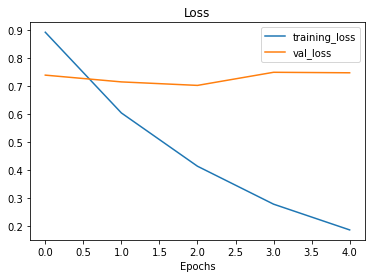

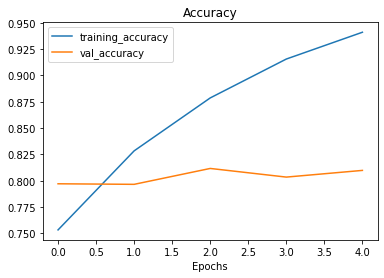

In [93]:
plot_loss_curves(history_101_food_classes_fine_tune_3)

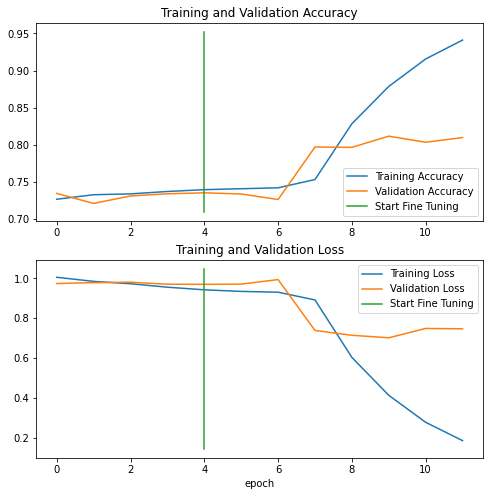

In [94]:
compare_historys(history_101_food_classes_feature_extract_3,history_101_food_classes_fine_tune_3)